In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve, inv
import statsmodels.api as sm

In [2]:
RC = {
    "figure.figsize": (10, 5),
}
sns.set_theme(style="whitegrid", rc=RC)

In [3]:
ROOT_PATH = Path().resolve()
DATA_PATH = ROOT_PATH / 'DST_BIL54.csv'
assert DATA_PATH.exists()

OUTPUT_DIR = ROOT_PATH / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Assignment 1

In [4]:
# Read and format data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])  # Coerce to dt
df = df[["time", "total"]]
df = df.rename(columns={"total": "y"})

# Construct x columns as requested
df["x"] = df["time"].dt.year + (df["time"].dt.month - 1 ) / 12

TRAINING_CUTOFF = datetime.fromisoformat("2024-01-01")
df_train = df[df['time'] < TRAINING_CUTOFF].copy()
df_test = df[df['time'] >= TRAINING_CUTOFF].copy()

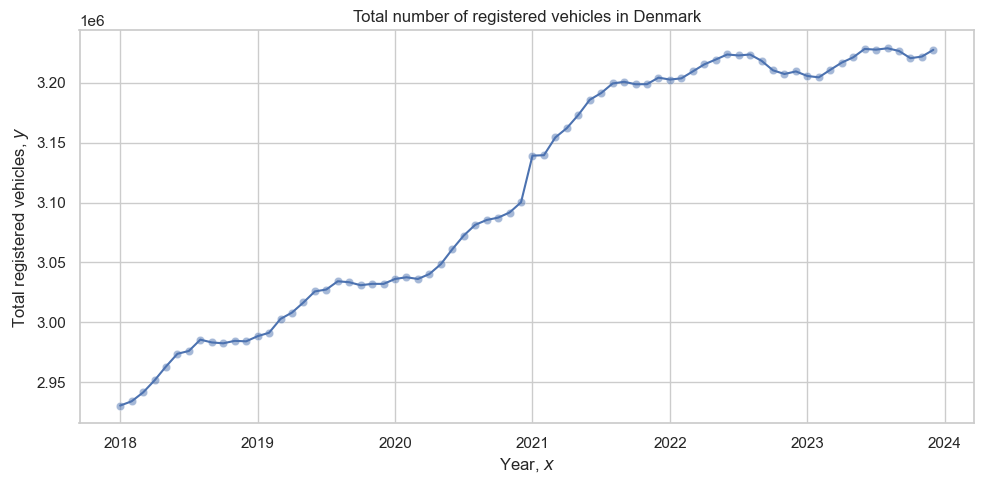

In [5]:
sns.lineplot(data=df_train, x="x", y="y")
sns.scatterplot(data=df_train, x="x", y="y", alpha=0.5)
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations.png", dpi=600)

# 1.2 Description of Data

We observe an increasing number of total registered vehicles in Denmark through the period from primo 2018 to ultimo 2023.
Notably, there is a sizable jump around the end of 2020, which flattens out in 2022. From 2022 onward we observe a smaller annual increase in the number of registered vehicles. This could be potentially be attributed to lower demand following the Coronavirus pandemic and the corresponding increase in remote working at many places of work. Alternatively, the reduction in the increase of registered cars could be seen as a consequence of increased fuel prices and uncertainty around the transition to Battery Electric Vehicles (BEV).



In [6]:
df_train[:3].round(3)

,time,y,x
0,2018-01-01,2930483,2018.000
1,2018-02-01,2934044,2018.083
2,2018-03-01,2941422,2018.167


## 2 - Linear Trend Model

We are given the following form of the General Linear Model (GLM):

$$
Y_t = θ_1 + θ_2 ⋅ x_t + ϵ_t
$$

### 2.1 - Matrix Form
We rewrite this in matrix-vector notation:

$$
\mathbf{\underbar{Y}} = \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}
$$

With $\mathbf{\underbar{\underbar{X}}}$ being the _design matrix_. In our case, for $N$ observations, this would be:

$$
\mathbf{\underbar{\underbar{X}}} ≡
\begin{bmatrix}
    1 & x_1 \\
    1 & x_2 \\
    ⋮ & ⋮ \\
    1 & x_n \\
\end{bmatrix}
$$

Using the first 3 time points in our training data set, we obtain:
$$
\begin{align}
\mathbf{\underbar{Y}}
&= \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}\\

\begin{bmatrix}
    y_1\\
    y_2\\
    y_3\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        1 & x_3 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\

\begin{bmatrix}
    2930483\\
    2934044\\
    2941422\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & 2018.000 \\
        1 & 2018.083 \\
        1 & 2018.167 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\
\end{align}
$$



### 2.2 - Parameter Estimates

We wish to solve for $\mathbf{\underbar{θ}}$:

$$
\mathbf{\underbar{θ}} = (X^T X)^{-1} X^T Y
$$

And obtain estimates of the standard error

In [7]:

# df_train = df_train.iloc[:3]
X = np.zeros((len(df_train["x"]), 2))
X[:, 0] = 1
X[:, 1] = df_train["x"]

n, p = X.shape

Y = df_train["y"]

theta = np.linalg.inv(X.T @ X) @ X.T @ Y
theta

Y_hat = X @ theta
epsilon = Y - Y_hat

RSS = epsilon.T @ epsilon
sigma2 = RSS / (n - p)
covariance = sigma2 * np.linalg.inv(X.T @ X)
variances = np.diag(covariance)
standard_errors = np.sqrt(variances)

print(theta)
print(standard_errors)

theta_pred = theta

thetas_OLS = theta


[-1.10355428e+08  5.61445562e+04]
[3.59358112e+06 1.77815630e+03]


In [31]:
# Verify against statsmodels implementation

Y_OLS = df_train["y"]
X_OLS = sm.add_constant(df_train["x"])
model = sm.OLS(Y_OLS, X_OLS)
results = model.fit()
results.params

const   -1.103554e+08
x        5.614456e+04
dtype: float64

In [8]:
# Prediction
df_prediction = df_train.copy()
X_prediction = np.empty((len(df_prediction["x"]), 2))
X_prediction[:, 0] = 1
X_prediction[:, 1] = df_prediction["x"]
df_prediction["y"] = X_prediction @ theta_pred

# TODO: Derive this in report
covariance_pred = sigma2 * (1 + X_prediction @ np.linalg.inv(X.T @ X) @ X_prediction.T)
variance_pred = np.diag(covariance_pred)
standard_errors_pred = np.sqrt(variance_pred)
p95_pred = 1.96 * standard_errors_pred
df_prediction["y_low"] = df_prediction["y"] - p95_pred
df_prediction["y_high"] = df_prediction["y"] + p95_pred


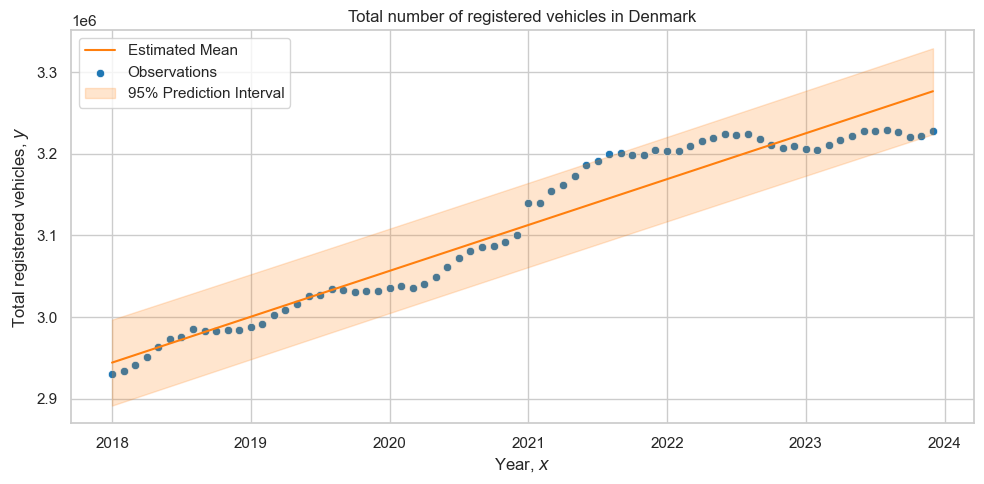

In [9]:
sns.lineplot(data=df_prediction, x="x", y="y", label="Estimated Mean", c="tab:orange")
sns.scatterplot(data=df_train, x="x", y="y", label="Observations", c="tab:blue")
plt.fill_between(df_prediction["x"], df_prediction["y_low"], df_prediction["y_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.legend()
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_predicted.png", dpi=600)

In [10]:
df_train

,time,y,x
0,2018-01-01,2930483,2018.000000
1,2018-02-01,2934044,2018.083333
2,2018-03-01,2941422,2018.166667
3,2018-04-01,2951498,2018.250000
4,2018-05-01,2963093,2018.333333
...,...,...,...
67,2023-08-01,3228835,2023.583333
68,2023-09-01,3226588,2023.666667
69,2023-10-01,3220559,2023.750000
70,2023-11-01,3221920,2023.833333


### 2.3 Prediction


In [11]:
rows_forecast = []
for i in range(12):
    rows_forecast.append({
        "time": datetime.fromisoformat(f"2024-{i + 1:02d}-01"),
        "x": 2024 + i / 12,
        "y": None
    })
df_forecast = pd.DataFrame(rows_forecast)
X_forecast = np.empty((len(df_forecast["x"]), 2))
X_forecast[:, 0] = 1
X_forecast[:, 1] = df_forecast["x"]
theta_pred = theta
df_forecast["y"] = X_forecast @ theta_pred

# Confidence intervals
covariance_forecast = sigma2 * (1 + X_forecast @ np.linalg.inv(X.T @ X) @ X_forecast.T)
variance_forecast = np.diag(covariance_forecast)
standard_errors_forecast = np.sqrt(variance_forecast)
p95_forecast = 1.96 * standard_errors_forecast
df_forecast["y_low"] = df_forecast["y"] - p95_forecast
df_forecast["y_high"] = df_forecast["y"] + p95_forecast

In [12]:
df_forecast_output = df_forecast[["x", "y", "y_low", "y_high"]].copy()
df_forecast_output["x"] = df_forecast_output["x"].map("{:.3f}".format)
df_forecast_output[["y", "y_low", "y_high"]] = df_forecast_output[["y", "y_low", "y_high"]].astype(int)
df_forecast_output = df_forecast_output.rename(columns={
    "x": "Time",
    "y": "Total Vehicles Registered",
    "y_low": "95% Confidence Interval, lower bound",
    "y_high": "95% Confidence Interval, upper bound",
})
df_forecast_output.to_csv(OUTPUT_DIR / "forecast.csv", index=False)

### 2.4 Plot of forecast

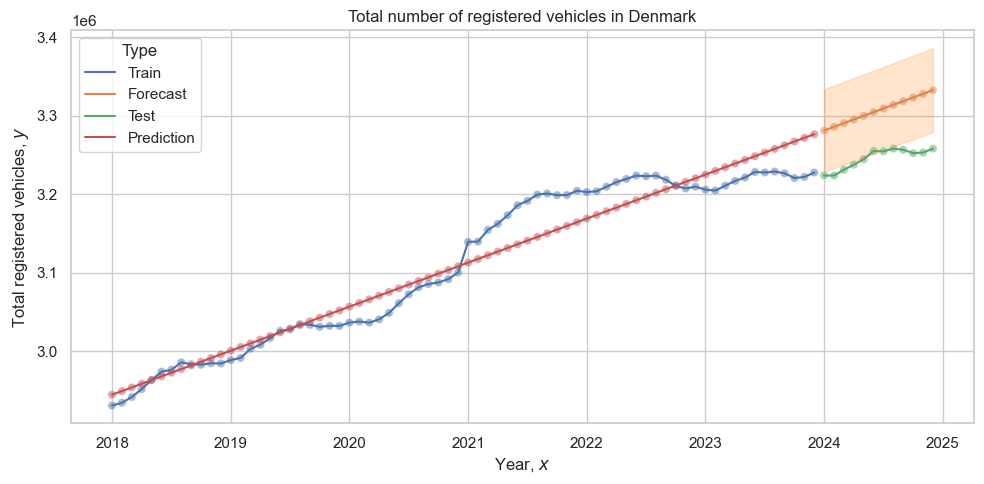

In [13]:
df_forecast["Type"] = "Forecast"
df_prediction["Type"] = "Prediction"
df_train["Type"] = "Train"
df_test["Type"] = "Test"
df_total = pd.concat([df_train, df_forecast, df_test, df_prediction])
# df_prediction
sns.lineplot(data=df_total, x="x", y="y", hue="Type")
sns.scatterplot(data=df_total, x="x", y="y", hue="Type", alpha=0.5, legend=False)
plt.fill_between(df_forecast["x"], df_forecast["y_low"], df_forecast["y_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_forecast.png", dpi=600)

### 2.6 Residuals

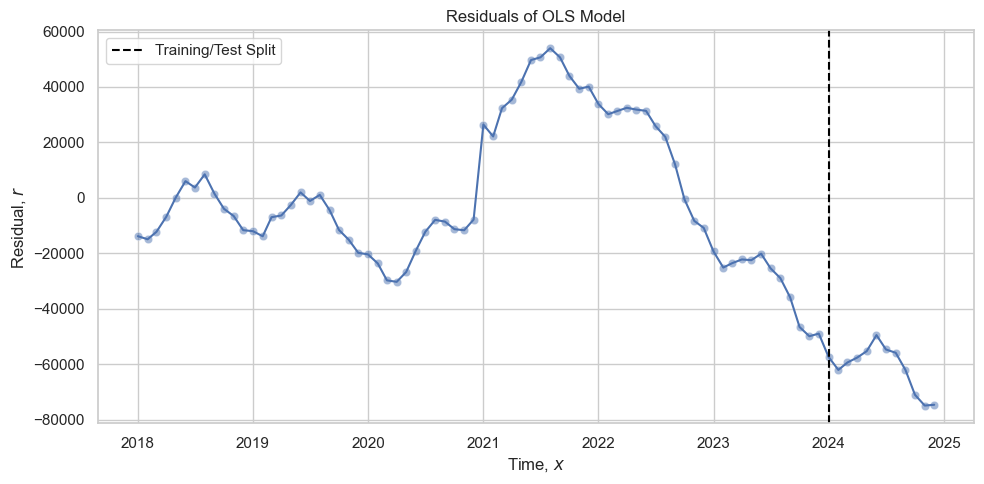

In [14]:
df_total_residual = df_total.copy()

df_residuals = df_total.pivot(index="time", columns="Type", values="y")
# df_residuals = df_residuals[["Forecast", "Test"]]
# df_residuals = df_residuals.dropna(axis="index")
df_residuals["residual"] = df_residuals["Test"] - df_residuals["Forecast"]
df_residuals["residual"] = df_residuals["residual"].fillna(df_residuals["Train"] - df_residuals["Prediction"])
sns.lineplot(data=df_residuals, x="time", y="residual")
sns.scatterplot(data=df_residuals, x="time", y="residual", alpha=0.5)
plt.title("Residuals of OLS Model")
plt.xlabel("Time, $x$")
plt.ylabel("Residual, $r$")
plt.axvline(TRAINING_CUTOFF, color="black", linestyle="--", label="Training/Test Split")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_2_6_forecast_residuals.png", dpi=600)

In [15]:
df_residuals
np.mean(df_residuals["residual"])

np.float64(-8738.578459950962)

## 3 WLS

### 3.2

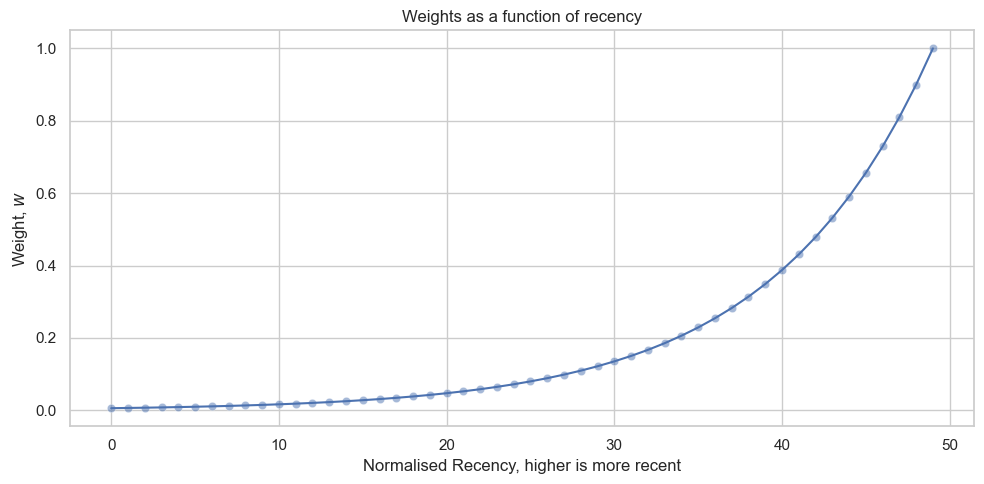

In [16]:
lambda_ = 0.9

N_times = 50
times = np.arange(N_times)
weights = np.asarray([lambda_ ** (N_times - i - 1) for i in times])

sns.lineplot(x=times, y=weights)
sns.scatterplot(x=times, y=weights, alpha=0.5)

plt.title("Weights as a function of recency")
plt.xlabel("Normalised Recency, higher is more recent")
plt.ylabel("Weight, $w$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_2_weights.png", dpi=600)

### 3.3

In [17]:

N_times = 72
times = np.arange(N_times)
weights = np.asarray([lambda_ ** (N_times - i - 1) for i in times])
np.sum(weights)

np.float64(9.994924712139436)

### 3.4

In [18]:

# df_train = df_train.iloc[:3]
X = np.zeros((len(df_train["x"]), 2))
X[:, 0] = 1
X[:, 1] = df_train["x"]

N = len(df_train)
times = np.arange(N)
weights = np.asarray([lambda_ ** (N - i - 1) for i in times])
W = np.diag(weights)

n, p = X.shape

Y = df_train["y"]

theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ Y
theta

Y_hat = X @ theta
epsilon = Y - Y_hat

RSS = epsilon.T @ W @ epsilon
total_memory = np.sum(W)
sigma2 = RSS / (total_memory - p)
covariance = sigma2 * np.linalg.inv(X.T @ W @ X)
variances = np.diag(covariance)
standard_errors = np.sqrt(variances)

print(theta)
print(standard_errors)

theta_pred = theta


[-5.24828618e+07  2.75299016e+04]
[1.51824147e+07 7.50427088e+03]


### 3.5

In [19]:
theta_pred = theta
df_forecast["y_wls"] = X_forecast @ theta_pred

# Confidence intervals
covariance_forecast = sigma2 + X_forecast @ covariance @ X_forecast.T
variance_forecast = np.diag(covariance_forecast)
standard_errors_forecast = np.sqrt(variance_forecast)
p95_forecast = 1.96 * standard_errors_forecast
df_forecast["y_wls_low"] = df_forecast["y_wls"] - p95_forecast
df_forecast["y_wls_high"] = df_forecast["y_wls"] + p95_forecast

In [20]:
df_forecast = df_forecast.rename(columns={
    "y": "y_ols",
    "y_low": "y_ols_low",
    "y_high": "y_ols_high",
})
df_forecast

,time,x,y_ols,y_ols_low,y_ols_high,Type,y_wls,y_wls_low,y_wls_high
0,2024-01-01,2024.000000,3.281154e+06,3.228504e+06,3.333803e+06,Forecast,3.237659e+06,3.197756e+06,3.277562e+06
1,2024-02-01,2024.083333,3.285832e+06,3.233124e+06,3.338541e+06,Forecast,3.239953e+06,3.199658e+06,3.280248e+06
2,2024-03-01,2024.166667,3.290511e+06,3.237742e+06,3.343280e+06,Forecast,3.242247e+06,3.201527e+06,3.282968e+06
3,2024-04-01,2024.250000,3.295190e+06,3.242358e+06,3.348022e+06,Forecast,3.244541e+06,3.203364e+06,3.285719e+06
4,2024-05-01,2024.333333,3.299869e+06,3.246973e+06,3.352764e+06,Forecast,3.246836e+06,3.205170e+06,3.288501e+06
5,2024-06-01,2024.416667,3.304547e+06,3.251586e+06,3.357508e+06,Forecast,3.249130e+06,3.206946e+06,3.291314e+06
6,2024-07-01,2024.500000,3.309226e+06,3.256198e+06,3.362254e+06,Forecast,3.251424e+06,3.208693e+06,3.294155e+06
7,2024-08-01,2024.583333,3.313905e+06,3.260809e+06,3.367001e+06,Forecast,3.253718e+06,3.210412e+06,3.297024e+06
8,2024-09-01,2024.666667,3.318583e+06,3.265418e+06,3.371749e+06,Forecast,3.256012e+06,3.212104e+06,3.299920e+06
9,2024-10-01,2024.750000,3.323262e+06,3.270025e+06,3.376499e+06,Forecast,3.258306e+06,3.213771e+06,3.302842e+06


In [21]:
dfm_forecast = df_forecast.melt(id_vars=["x"], value_vars=["y_ols", "y_wls"])
dfm_forecast["Type"] = "Forecast (" + dfm_forecast["variable"].str.replace("y_", "").str.upper() + ")"
dfm_forecast["y"] = dfm_forecast["value"]
dfm_forecast = dfm_forecast.drop(columns=["variable", "value"])
# df_total

In [22]:
df_total= pd.concat([df_train, dfm_forecast, df_test])
df_total

,time,y,x,Type
0,2018-01-01,2930483.0,2018.000000,Train
1,2018-02-01,2934044.0,2018.083333,Train
2,2018-03-01,2941422.0,2018.166667,Train
3,2018-04-01,2951498.0,2018.250000,Train
4,2018-05-01,2963093.0,2018.333333,Train
...,...,...,...,...
79,2024-08-01,3258060.0,2024.583333,Test
80,2024-09-01,3256515.0,2024.666667,Test
81,2024-10-01,3252275.0,2024.750000,Test
82,2024-11-01,3253059.0,2024.833333,Test


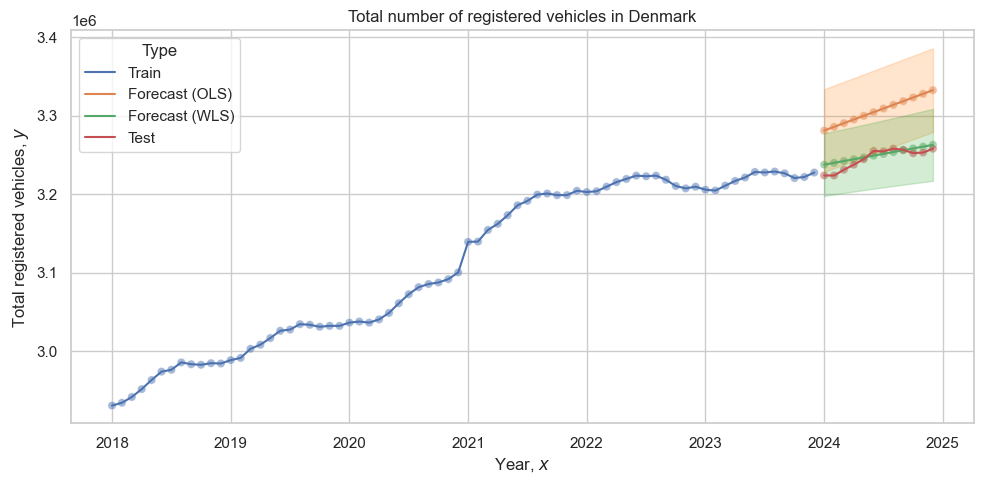

In [23]:
# df_prediction
sns.lineplot(data=df_total, x="x", y="y", hue="Type")
sns.scatterplot(data=df_total, x="x", y="y", hue="Type", alpha=0.5, legend=False)
plt.fill_between(df_forecast["x"], df_forecast["y_ols_low"], df_forecast["y_ols_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.fill_between(df_forecast["x"], df_forecast["y_wls_low"], df_forecast["y_wls_high"], color="tab:green", alpha=0.2, label="95% Prediction Interval")
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_5_forecast_wls_ols.png", dpi=600)

0.99
[-1.07098187e+08  5.45329737e+04]
0.95
[-8.69395339e+07  4.45633447e+04]
0.9
[-5.24828618e+07  2.75299016e+04]
0.8
[-2.15279735e+07  1.22311472e+04]
0.7
[-1.57399787e+07  9.37098201e+03]
0.6
[-1.13240712e+07  7.18894591e+03]


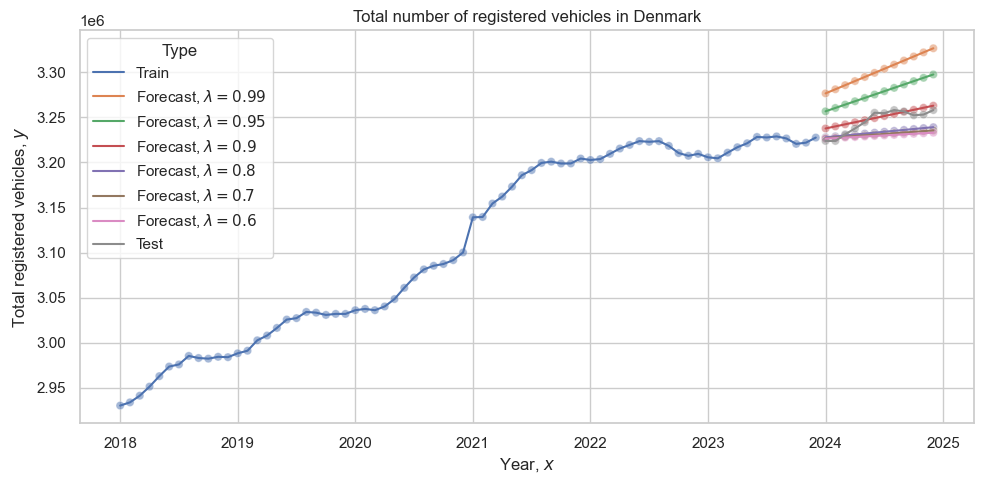

In [39]:
def predict(lambda_):
    print(lambda_)
    dff = pd.DataFrame()
    # df_train = df_train.iloc[:3]
    X = np.zeros((len(df_train["x"]), 2))
    X[:, 0] = 1
    X[:, 1] = df_train["x"]

    N = len(df_train)
    times = np.arange(N)
    weights = np.asarray([lambda_ ** (N - i - 1) for i in times])
    W = np.diag(weights)

    N, p = X.shape

    Y = df_train["y"]

    theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ Y

    Y_hat = X @ theta
    epsilon = Y - Y_hat

    RSS = epsilon.T @ W @ epsilon
    total_memory = np.sum(W)
    sigma2 = RSS / (total_memory - p)
    covariance = sigma2 * np.linalg.inv(X.T @ W @ X)
    variances = np.diag(covariance)
    standard_errors = np.sqrt(variances)

    # print(theta)
    # print(standard_errors)

    theta_pred = theta
    print(theta_pred)
    dff["y"] = X_forecast @ theta_pred
    dff["x"] = X_forecast[:, 1]

    # Confidence intervals
    covariance_forecast = sigma2 + X_forecast @ covariance @ X_forecast.T
    variance_forecast = np.diag(covariance_forecast)
    standard_errors_forecast = np.sqrt(variance_forecast)
    p95_forecast = 1.96 * standard_errors_forecast
    dff["y_low"] = dff["y"] - p95_forecast
    dff["y_high"] = dff["y"] + p95_forecast
    dff["lambda"] = lambda_

    return dff

dfs = []
for lambda_ in [0.99, 0.95, 0.90, 0.8, 0.7, 0.6]:
    dfs.append(predict(lambda_))

df_forecast2 = pd.concat(dfs)
df_forecast2["Type"] = "Forecast, $λ=" + df_forecast2["lambda"].astype("str") + "$"
df_total= pd.concat([df_train, df_forecast2, df_test])
# df_prediction
sns.lineplot(data=df_total, x="x", y="y", hue="Type")
sns.scatterplot(data=df_total, x="x", y="y", hue="Type", alpha=0.5, legend=False)
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_6_forgetting_factors.png", dpi=600)



In [42]:
# Verify against WLS from statsmodels
Y_WLS = df_train["y"]
X_WLS = sm.add_constant(df_train["x"])
weights = lambda_ ** np.arange(len(df_train))[::-1]
model_WLS = sm.WLS(Y_WLS, X_WLS, weights=weights)
results_WLS = model_WLS.fit()
results_WLS.params

const   -1.132407e+07
x        7.188946e+03
dtype: float64

# 4


## 4.2

array([[-51837.16474871],
       [  1561.56703233]])

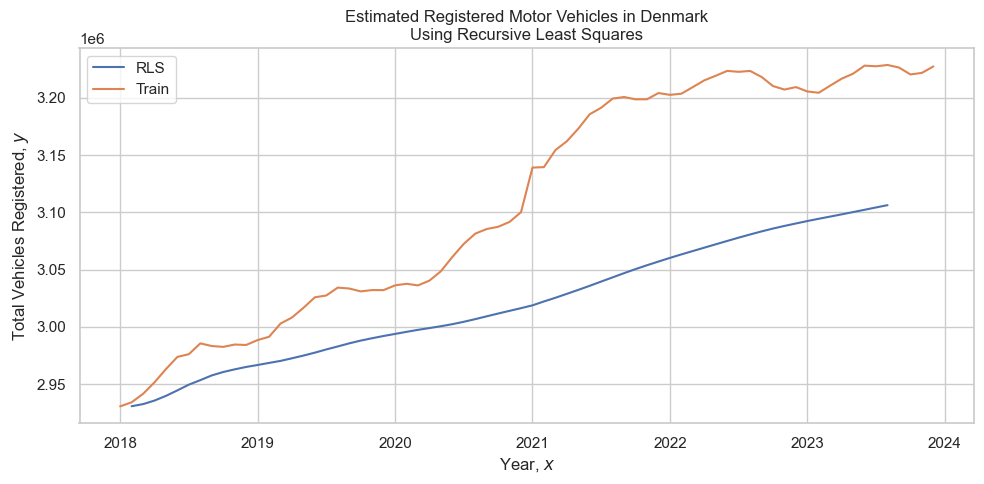

In [97]:
def iterate(R, theta, x_t, y_t):
    """
    Updates matrix R and parameter vector theta using observations
    in vector x_t corresponding to outcome scalar y_t.

    Arguments:
        R: Matrix of shape (N, N) where N is the number of features.

        theta: Vector of shape (N, 1) where N is the number of features.
            Parameters of GLM model
        x_t: Vector of shape (N, 1) where N is the number of features.
            Exogenous variables of observations.
        y_t: Scalar outcome.
            Endogenous variable of observations.


    Vectors are columns vectors.
    """
    N = x_t.shape[0]
    assert R.shape == (N, N)
    assert theta.shape == (N, 1)
    assert x_t.shape == (N, 1)
    assert y_t.shape == tuple()

    R_t = R + x_t @ x_t.T
    # theta_t = theta + (inv(R_t) @ x_t) * (y_t - x_t.T @ theta)
    theta_t = theta + inv(R_t) @ x_t @ (y_t - x_t.T @ theta)

    return R_t, theta_t

R_0 = 0.1 * np.eye(2)
# R_0 = inv(X.T @ X)  # Good start guess
theta_0 = np.zeros((2, 1))
# theta_0 = thetas_OLS[:, None]

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
t_stop = X.shape[0] - 3 - 1  # Assuming up to t-3 is not inclusive
thetas_rls_1 = np.empty((t_stop+1, 2))
thetas_rls_1[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]


    R, theta = iterate(R, theta, x_t, y_t)
    thetas_rls_1[i+1, :] = theta.T

R
theta

y = []
x = []
for i in range(thetas_rls_1.shape[0] - 1):
    y_pred = X @ thetas_rls_1[i, :].T
    y.append(y_pred[i])
    x.append(X[i, 1])
K = 1

plt.figure()
plt.plot(x[K:], y[K:], label="RLS")
sns.lineplot(df_train, x="x", y="y", label="Train")
plt.title("Estimated Registered Motor Vehicles in Denmark\nUsing Recursive Least Squares")
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_2_rls.png", dpi=600)

theta

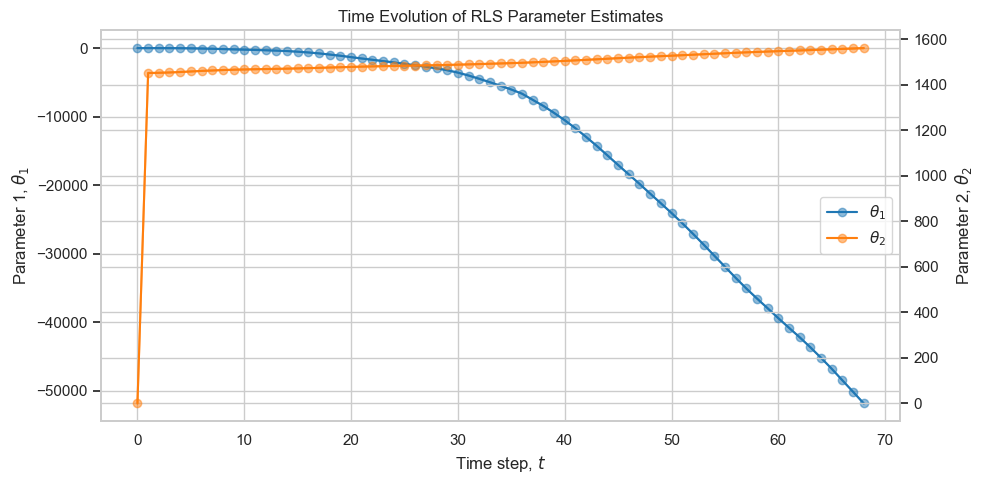

In [88]:
plt.figure()
t = np.arange(thetas_rls_1.shape[0])
thetas_1_l, = plt.plot(t, thetas_rls_1[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rls_1[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time step, $t$")
plt.ylabel("Parameter 1, $θ_1$")

ax2 = plt.twinx()
plt.ylabel("Parameter 2, $θ_2$")
# thetas_2 = sns.lineplot(thetas_rls_1[:, 1], label="$θ_2$", c="tab:orange")
thetas_2_l, = plt.plot(t, thetas_rls_1[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rls_1[:, 1], c="tab:orange", alpha=0.5, marker="o")
plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1$", "$θ_2$"], loc="center right")
plt.title("Time Evolution of RLS Parameter Estimates")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_2_rls_parameters.png", dpi=600)

## 4.3

In [ ]:
### RLS bad start full data
R_0 = 0.1 * np.eye(2)
# R_0 = inv(X.T @ X)  # Good start guess
theta_0 = np.zeros((2, 1))
# theta_0 = theta_pred[:, None]

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
thetas_rls_2 = np.empty((t_stop+1, 2))
thetas_rls_2[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = iterate(R, theta, x_t, y_t)
    thetas_rls_2[i+1, :] = theta.T

R
theta

array([[-58319.43118089],
       [  1567.95964503]])

In [98]:
# Verify against statsmodels
Y_RLS = df_train["y"]
X_RLS = sm.add_constant(df_train["x"])
model_RLS = sm.RecursiveLS(Y_RLS, X_RLS)
results_RLS = model_RLS.fit()
results_RLS.params

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignment1\.venv\Lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1762: RuntimeWarning: invalid value encountered in scalar divide
  self.scale = np.sum(scale_obs[d:]) / nobs_k_endog


const   -1.173681e+08
x        5.961208e+04
dtype: float64

In [107]:
thetas_OLS

array([-1.10355428e+08,  5.61445562e+04])

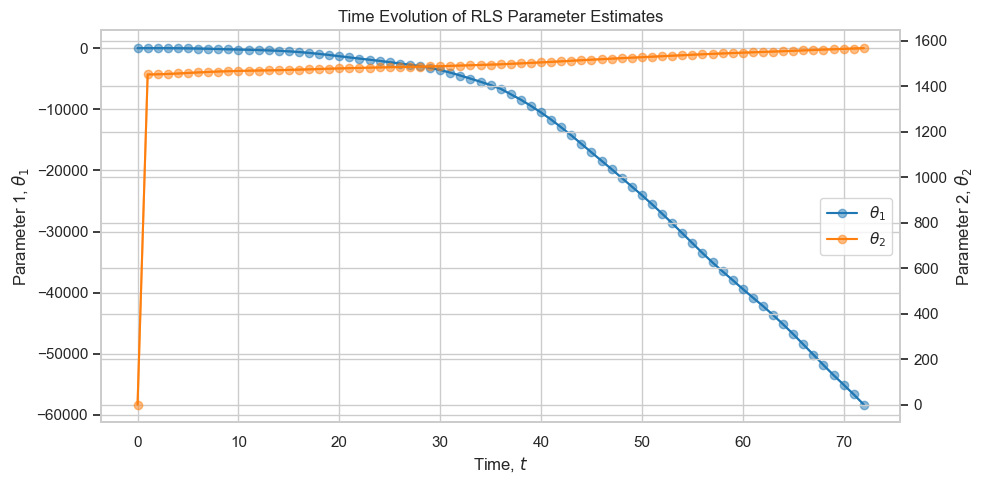

In [104]:
fig, ax1 = plt.subplots()
t = np.arange(thetas_rls_2.shape[0])
# df_thetas_rls = pd.DataFrame(thetas_rls_1, columns=["$θ_1$", "$θ_2$"])
thetas_1_l, = plt.plot(t, thetas_rls_2[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rls_2[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time, $t$")
plt.ylabel("Parameter 1, $θ_1$")

ax2 = plt.twinx()
plt.ylabel("Parameter 2, $θ_2$")
# thetas_2 = sns.lineplot(thetas_rls_1[:, 1], label="$θ_2$", c="tab:orange")
thetas_2_l, = plt.plot(t, thetas_rls_2[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rls_2[:, 1], c="tab:orange", alpha=0.5, marker="o")

# plt.plot(t, thetas_OLS[0] * np.ones_like(t), c="tab:blue", linestyle="--")
plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1$", "$θ_2$"], loc="center right")
plt.title("Time Evolution of RLS Parameter Estimates")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_3_rls_parameters.png", dpi=600)

In [106]:
df_train

,time,y,x,Type
0,2018-01-01,2930483,2018.000000,Train
1,2018-02-01,2934044,2018.083333,Train
2,2018-03-01,2941422,2018.166667,Train
3,2018-04-01,2951498,2018.250000,Train
4,2018-05-01,2963093,2018.333333,Train
...,...,...,...,...
67,2023-08-01,3228835,2023.583333,Train
68,2023-09-01,3226588,2023.666667,Train
69,2023-10-01,3220559,2023.750000,Train
70,2023-11-01,3221920,2023.833333,Train


In [ ]:
theta_pred

array([-5.24828618e+07,  2.75299016e+04])

In [ ]:
X.shape

(72, 2)